# Testing the Performance of Coin Model at Low C Rate

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


In [2]:
chemistry = pybamm.parameter_sets.Ecker2015_v2
var = pybamm.standard_spatial_vars

Model 1, DFN coin

In [3]:
# choose DFN
model1 = pybamm.lithium_ion. DFN(build=False)
# add rho_n
model1.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model1.param.R_n,
    }
)
# delete r_n
model1.variables.pop('r_n', None)
model1.variables.pop('r_n [m]', None)
model1.build_model()

Model 2, SPMe coin

In [4]:
# choose SPMe
model2 = pybamm.lithium_ion. SPMe(build=False)
model2.variables

{'Time': Time(0x66eeb6b8433c94d9, time, children=[], domain=[], auxiliary_domains={}),
 'Time [s]': Multiplication(-0x6cba65740f71ae8c, *, children=['time', '96485.33212 * Maximum concentration in negative electrode [mol.m-3] * Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m] / function (absolute)'], domain=[], auxiliary_domains={}),
 'Time [min]': Division(-0x2e5146133362db7c, /, children=['time * 96485.33212 * Maximum concentration in negative electrode [mol.m-3] * Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m] / function (absolute)', '60.0'], domain=[], auxiliary_domains={}),
 'Time [h]': Division(-0x55709e536ec0094d, /, children=['time * 96485.33212 * Maximum concentration in negative electrode [mol.m-3] * Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m] / function (absolute)', '3600.0'], domain=[], auxiliary_domains={}),
 'x': SpatialVariable(-0x

In [5]:
# add rho_n
model2.variables.update(
    {
        "rho_n": var.rho_n,
        "rho_n [m]": var.rho_n * model2.param.R_n,
    }
)
# delete r_n
model2.variables.pop('r_n', None)
model2.variables.pop('r_n [m]', None)
model2.build_model()

Model 3, DFN spherical

Model 4, SPMe spherical

In [6]:
# choose DFN
model3 = pybamm.lithium_ion.DFN()
# choose SPMe
model4 = pybamm.lithium_ion.SPMe()

Parameter set 1, coin

In [7]:
# pick parameters, keeping C-rate as an input to be changed for each solve
parameter_values1 = pybamm.ParameterValues(chemistry=chemistry)
parameter_values1.update({"Current function [A]": "[input]"})
parameter_values1.update({"Negative particle radius [m]": 2.1e-05})
parameter_values1.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_4"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry['anode'])

Parameter set 2, spherical

In [8]:
parameter_values2 = pybamm.ParameterValues(chemistry=chemistry)
parameter_values2.update({"Current function [A]": "[input]"})
parameter_values1.update({"Negative electrode diffusivity [m2.s-1]": "[function]graphite_diffusivity_Ecker2015_up"},
                        path="pybamm/input/parameters/lithium-ion/anodes/" + chemistry['anode'])

In [9]:
# coin
var_pts1 = {
    var.x_n: int(parameter_values1.evaluate(model2.param.L_n / 1e-6)),
    var.x_s: int(parameter_values1.evaluate(model2.param.L_s / 1e-6)),
    var.x_p: int(parameter_values1.evaluate(model2.param.L_p / 1e-6)),
    var.rho_n: 1000,
    var.r_p: int(parameter_values1.evaluate(model2.param.R_p / 1e-7)),
}
# spherical
var_pts2 = {
    var.x_n: int(parameter_values2.evaluate(model4.param.L_n / 1e-6)),
    var.x_s: int(parameter_values2.evaluate(model4.param.L_s / 1e-6)),
    var.x_p: int(parameter_values2.evaluate(model4.param.L_p / 1e-6)),
    var.r_n: int(parameter_values2.evaluate(model4.param.R_n / 1e-7)),
    var.r_p: int(parameter_values2.evaluate(model4.param.R_p / 1e-7)),
}

In [10]:
sim1 =  pybamm.Simulation(model2, parameter_values=parameter_values1, var_pts=var_pts1, geometry=pybamm.battery_geometry(coin_geometry=True))
sim2 =  pybamm.Simulation(model4, parameter_values=parameter_values2, var_pts=var_pts2)

In [11]:
parameter_values1

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.26,
 'Cell capacity [A.h]': 0.15625,
 'Cell cooling surface area [m2]': 0.0172,
 'Cell volume [m3]': 1.61e-06,
 'Current function [A]': InputParameter(-0x16840d6ea70b7e3f, Current function [A], children=[], domain=[], auxiliary_domains={}),
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 0.3,
 'Electrode height [m]': 0.10099999999999999,
 'Electrode width [m]': 0.085,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Ecker2015 at 0x7fc82c8c1a70>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Ecker2015 at 0x7fc82c8c18c0>,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 26120.05,
 'Initial concentration in positive electrode [mol.m-3]': 1263

## Pseudo-OCV

In [12]:
C_rates = [1/20]  # C-rates to solve for
capacity = parameter_values1["Cell capacity [A.h]"]
t_evals = [np.linspace(0, 120800, 10000)] * len(C_rates) # times to return the solution at
solutions3 = [None] * len(C_rates)  # empty list that will hold solutions
current3 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions3[i] = sim1.solution
    current3 = np.append(current3, current)

In [13]:
C_rates = [1/20]  # C-rates to solve for
capacity = parameter_values2["Cell capacity [A.h]"]
t_evals = [np.linspace(0, 100800, 10000)] * len(C_rates) # times to return the solution at
solutions4 = [None] * len(C_rates)  # empty list that will hold solutions
current4 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions4[i] = sim2.solution
    current4 = np.append(current4, current)

In [14]:
# load ocv data
voltage_data = pd.read_csv("pybamm/input/discharge_data/Ecker_OCV1.csv", header=None).to_numpy()

2020-08-21 15:49:12,289 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')
2020-08-21 15:49:37,271 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


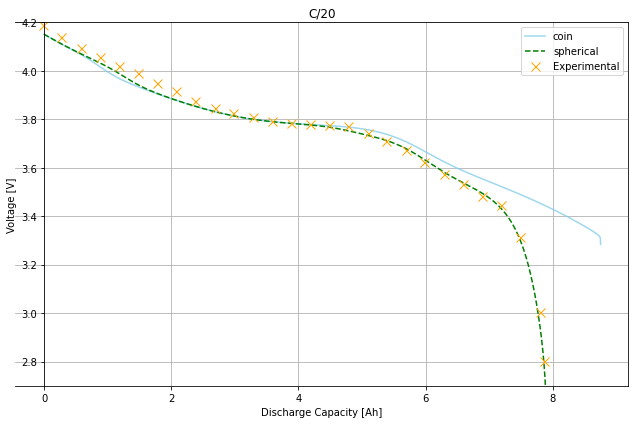

In [15]:
plt.figure(figsize=[9,6])
ax = plt.gca()
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(['data',2.7])
ax.spines['left'].set_position(['data',0])
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the C/20 results
t_sol3 = solutions3[0]["Time [s]"].entries
t_sol4 = solutions3[0]["Time [s]"].entries
ax.plot((current3[0] * t_sol3 * 48)/3600, solutions3[0]["Terminal voltage [V]"](t_sol3), label="coin", color="skyblue", alpha=0.8)
ax.plot((current4[0] * t_sol4 * 48)/3600, solutions4[0]["Terminal voltage [V]"](t_sol4), label="spherical", color="green", linestyle='--')
ax.plot(voltage_data[:,0], voltage_data[:,1], marker="x", color='orange', label='Experimental', markersize=9, linestyle='')
ax.set_xlabel("Discharge Capacity [Ah]")
ax.set_ylabel("Voltage [V]")
ax.set_title("C/20")
ax.legend(loc="best")
ax.grid()

#plt.xlim(0,9)
plt.ylim(2.7,4.2)
plt.tight_layout()
#plt.savefig('OCV')
plt.show()

In [16]:
solutions3[0]["Terminal voltage [V]"](t_sol3)

2020-08-21 15:49:38,656 - [WARNING] processed_variable.__call__(510): Calling variable outside interpolation range (returns 'nan')


array([4.15145766, 4.15095558, 4.15067179, ...,        nan,        nan,
              nan])

## Varying C-rate

In [17]:
C_rates = [0.25, 1, 3, 5]  # C-rates to solve for
capacity = parameter_values1["Cell capacity [A.h]"]
t_evals = [np.linspace(0, 20000, 10000)] * len(C_rates) # times to return the solution at
solutions1 = [None] * len(C_rates)  # empty list that will hold solutions
current1 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim1.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions1[i] = sim1.solution
    current1 = np.append(current1, current)

rhs failed: KeyboardInterrupt
At t = 0.170357, the right-hand side routine failed in an unrecoverable manner.


SolverError: .../casadi/interfaces/sundials/cvodes_interface.cpp:380: CVode returned "CV_RHSFUNC_FAIL". Consult CVODES documentation.

In [ ]:
C_rates = [0.25, 1, 3, 5]  # C-rates to solve for
capacity = parameter_values2["Cell capacity [A.h]"]
t_evals = [np.linspace(0, 20000, 10000)] * len(C_rates) # times to return the solution at
solutions2 = [None] * len(C_rates)  # empty list that will hold solutions
current2 = np.array([])

# loop over C-rates
for i, C_rate in enumerate(C_rates):
    current = C_rate * capacity
    sim2.solve(t_eval=t_evals[i], solver=pybamm.CasadiSolver(mode="fast"),inputs={"Current function [A]": current})
    solutions2[i] = sim2.solution
    current2 = np.append(current2, current)

In [ ]:
plt.figure(figsize=[9,6])
ax = plt.gca()
# plot the 0.25C - 5C results
t_sol1c = solutions1[1]["Time [s]"].entries
t_sol1s = solutions2[1]["Time [s]"].entries
t_sol2c = solutions1[2]["Time [s]"].entries
t_sol2s = solutions2[2]["Time [s]"].entries
t_sol3c = solutions1[3]["Time [s]"].entries
t_sol3s = solutions2[3]["Time [s]"].entries
t_sol4c = solutions1[4]["Time [s]"].entries
t_sol4s = solutions2[4]["Time [s]"].entries
ax.plot((current1[1] * t_sol1c * 48)/3600, solutions1[1]["Terminal voltage [V]"](t_sol1c), label="0.25C coin", color="green", alpha=0.8)
ax.plot((current2[1] * t_sol1s * 48)/3600, solutions2[1]["Terminal voltage [V]"](t_sol1s), label="0.25C spherical", color="green", linestyle='--')
ax.plot((current1[2] * t_sol2c * 48)/3600, solutions1[2]["Terminal voltage [V]"](t_sol2c), label="1C coin", color="skyblue", alpha=0.8)
ax.plot((current2[2] * t_sol2s * 48)/3600, solutions2[2]["Terminal voltage [V]"](t_sol2s), label="1C spherical", color="skyblue", linestyle='--')
ax.plot((current1[3] * t_sol3c * 48)/3600, solutions1[3]["Terminal voltage [V]"](t_sol3c), label="3C coin", color="pink", alpha=0.8)
ax.plot((current2[3] * t_sol3s * 48)/3600, solutions2[3]["Terminal voltage [V]"](t_sol3s), label="3C spherical", color="pink", linestyle='--')
ax.plot((current1[4] * t_sol4c * 48)/3600, solutions1[4]["Terminal voltage [V]"](t_sol4c), label="5C coin", color="brown", alpha=0.8)
ax.plot((current2[4] * t_sol4s * 48)/3600, solutions2[4]["Terminal voltage [V]"](t_sol4s), label="5C spherical", color="brown", linestyle='--')
ax.set_xlabel("Discharge Capacity [Ah]")
ax.set_ylabel("Voltage [V]")
ax.set_title("0.25C - 5C, 25 °C")
ax.legend(loc="best")

plt.ylim(2.7,4.2)
plt.tight_layout()
plt.show()